# Sketch learning with synthetic data

We generate data points from the sum of two gaussian distributions to see if the sketch learning algorithm compares at all well with the traditional EM method.

In [1]:
import numpy as np
import math
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Math, Latex

import chart_studio as py
import plotly.figure_factory as FF
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as offline
import plotly.io as pio

offline.init_notebook_mode()

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

pio.orca.config.executable = '/Applications/orca.app/Contents/MacOS/orca'
pio.orca.config.save()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def cm_2_rgbstr(c):
    return f'rgb({int(round(c[0]*255))}, {int(round(c[1]*255))}, {int(round(c[2]*255))})'
def cma_2_rgbstr(c, a):
    return f'rgba({int(round(c[0]*255))}, {int(round(c[1]*255))}, {int(round(c[2]*255))}, {a})'
def col_2_scale(c, div=10):
    zs = np.linspace(0.,1.,div+1,endpoint=True)
    cs = [[z, cm_2_rgbstr(1.0 - z * (1.0 -  np.array(c)))] for z in zs]
    return cs

cm=sns.color_palette('Set1', n_colors=13)
axis_layout = dict(autorange=False, showgrid=False, zeroline=False, showline=False, 
                   ticks='', showticklabels=False, title='')
layout = go.Layout(width=800, height=400, showlegend=False,
                   margin=go.layout.Margin(l=40, r=40, b=20, t=20, pad=10),
                   xaxis=axis_layout, yaxis=axis_layout,
                   paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)',
                   title={'text':'','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
layout['xaxis'].update(range=[-2.4, 2.4])
layout['yaxis'].update(range=[-1.2, 1.2])

sample_marker = dict(color=cma_2_rgbstr(cm[0], 0.7), size=4, symbol='circle')
mean_marker = dict(color=cm_2_rgbstr((0,0,0)), size=4, symbol='square', line=dict(color=cm_2_rgbstr((0,0,0)), width=3))
param_marker = dict(color=cm_2_rgbstr(cm[0]), size=4, symbol='circle')

def make_ellipse(mean, V, sigma, color=(0,0,0), opacity=0.5):
    phi = np.linspace(0, 2*math.pi)
    x = np.sin(phi)*sigma[0]*V[0,0] + np.cos(phi)*sigma[1]*V[0,1]
    y = np.sin(phi)*sigma[0]*V[1,0] + np.cos(phi)*sigma[1]*V[1,1]
    return go.Scatter(x=mean[0] + x.flatten(),y=mean[1] + y.flatten(), 
                       mode='lines', line=dict(width=1.5, color=cma_2_rgbstr(color, opacity)), showlegend=False)

#def make_gaussian_plot(mean, V, sigma, color=(0,0,0), opacity=0.5):
    # Makes a collection of Plotly graph objects: The mean, the ellipse corresponding to 1 x Sigma,
    # and the ellipse corresponding to 2 x sigma
    #fig_gaussian = [make_ellipse(mean, V, sigma)]
    #fig_gaussian.append(make_ellipse(mean, V, 2*sigma))
    #fig_gaussian.append(go.Scatter(x=[mean[0]], y=[mean[1]], mode='markers', marker=mean_marker, showlegend=False))
    #return fig_gaussian

In [4]:
d = 2 # This is the dimension parameter... can change it later
R2 = hil.Space(d)
def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

# 200 points on the [0,1]^2 square
n_samps = np.array([120, 80])
n_points = n_samps.sum()
n_gaussians = len(n_samps)
means = np.array([[0.7, 0.1], [-0.2, -0.2]])
phis = np.array([rot(np.pi/6), rot(-np.pi/4)])
sigmas = np.array([[0.6, 0.2], [0.6, 0.1]])

points = np.zeros((2,0))
fig_ellipses = []
for i in range(n_gaussians):
    # Make the random samples for each gaussian
    points_i = phis[i] @ (sigmas[i] * np.random.randn(2, n_samps[i]).T).T + np.atleast_2d(means[i]).T

    points = np.concatenate((points, points_i), axis=1)
    # Make the graphing objects
    fig_ellipses.append(make_ellipse(means[i], phis[i], sigmas[i]))
    fig_ellipses.append(make_ellipse(means[i], phis[i], 2*sigmas[i]))
    fig_ellipses.append(go.Scatter(x=[means[i,0]], y=[means[i,1]], mode='markers', marker=mean_marker, showlegend=False))

sorter = np.argsort(points[0])
points = points.T[sorter].T

fig_data = [go.Scatter(x=points[0,:], y=points[1,:], mode='markers', marker=sample_marker, showlegend=False)]
#layout['title']['text']=f'Generated data points'
fig = go.Figure(data=fig_data+fig_ellipses, layout=layout)
fig.layout['title']['text']=f'Generated data points'
offline.iplot(fig)

### We need to do empirical PCA, so lets define a routine

In [5]:
_TOL = 1e-10
# Calculate the PCA of a collection of samples with possible sparsity
def pca_from_samples(points, weights=None, eig_tol=_TOL):
    # A PCA with an optional weights (which is used in the EM algorithm)
    # Assumes the points are given as row vectors
    n = points.shape[1]
    
    if weights is None:
        norm_weights = np.ones(n) / n
    else:
        if weights.sum() <= _TOL:
            return None
        norm_weights = weights / weights.sum()

    mean = points @ norm_weights
    points_mf = (points.T - mean).T
    G = points_mf.T @ points_mf
    
    sig_sq, V = sp.linalg.eigh((G * np.sqrt(norm_weights)).T * np.sqrt(norm_weights))

    # We reverse the eigenvecs and eigenvalues as they are ordered smallest to largest
    V = V[:,::-1]
    sig_sq = sig_sq[::-1] 
    # And cut off at the tolerance level
    V = V[:,sig_sq > eig_tol]
    sig_sq = sig_sq[sig_sq > eig_tol]
    sig_resid_sq = sig_sq[sig_sq <= eig_tol]

    PCA_basis = points_mf @ ((np.sqrt(1.0/sig_sq) * V).T * np.sqrt(norm_weights)).T
    return PCA_basis, sig_sq, mean, np.sqrt(np.abs(sig_resid_sq).sum())

pca_phi, pca_sigma_sq, mean, resid_sq = pca_from_samples(points)
pca_sigma = np.sqrt(pca_sigma_sq)

# We re-center the points around the mean, for convenience
points = (points.T - mean).T
mean -= mean
fig_data = [go.Scatter(x=points[0,:], y=points[1,:], mode='markers', marker=sample_marker, showlegend=False)]

fig_pca = [make_ellipse(mean, pca_phi, np.sqrt(pca_sigma_sq)), 
           make_ellipse(mean, pca_phi, 2*np.sqrt(pca_sigma_sq)),
           go.Scatter(x=[mean[0]], y=[mean[1]], mode='markers', marker=mean_marker, showlegend=False)]
for s, v in zip(pca_sigma, pca_phi.T):
    fig_v = go.Scatter(x=[mean[0],mean[0]+s*v[0]], y=[mean[1],mean[1]+s*v[1]],
                       mode='lines', line=dict(width=1.5, color='rgba(0,0,0,0.5)'), showlegend=False)
    fig_pca.append(fig_v)

fig = go.Figure(data=fig_data+fig_pca, layout=layout)
fig.layout['title']['text']=f'PCA of data points'
offline.iplot(fig)

## Ok, here we go with the sketch learning, a rough breakdown in to steps

 - Pick $m$, which I thin kmust just be a bit more than the desired sparsity. Generate a sketching operator $A$ of $m$ randomly chosen moments
 - Generate the empirical sketch $\hat z = A \hat P = \frac{1}{n_{points}\sqrt{n_{sketches}}}\sum_{i=1}^{n_{points}} M_j (x_i)$
 - Set $\Theta = \emptyset$. Now loop the following:
   - Maximise $\left\langle \frac{A P_\theta}{\| A P_\theta\|}, \hat r\right\rangle_2$, possibly w/ gradient descent
   - $\Theta = \Theta \cup \theta$
   - Adjust the weights $\alpha = \arg\min_{\alpha} \| \hat z - \sum_{k=1}^{|\Theta|} \alpha_k A P_\theta \|_2$
   - Now adjust all parameters through gradient descent (??), that is both $\Theta$ and $\alpha$ at the same time
   
How to chose a sketching operator: random moments. Set $M_j = \exp(-i \omega_j^T x)$ where the $\omega_j$ are chosen randomly in the support of the space, or at least in the support. Lets get to it!

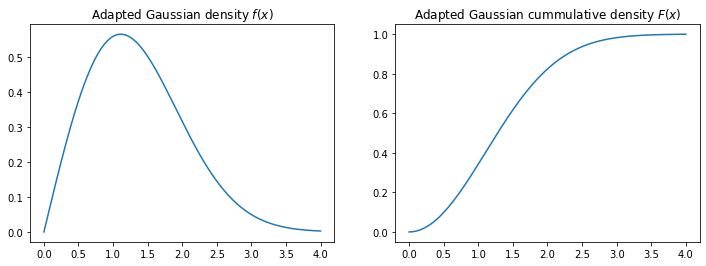

<IPython.core.display.Latex object>

[0.04368761 0.36590254 0.00233636 0.67197351]


<IPython.core.display.Latex object>

[0.32855094 1.04084687 0.07525429 1.61272987]


<IPython.core.display.Latex object>

[ 1.80411242e-16 -1.66533454e-16 -5.26488575e-16  1.11022302e-16]


In [6]:
# The frequencies are chosen with a special design, either Gaussian or "adapted Gaussian"
def adapted_gaussian(x):
    return 4 * np.sqrt(x*x + 0.25 * x**4) * np.exp(-0.5 * x*x) / (np.sqrt(2*np.pi) * np.exp(2))
# for which the cumulative / integral is
def adapted_gaussian_cummulative(x):
    sq_x_4 = np.sqrt(x*x + 4)
    return (sp.special.erf(sq_x_4/np.sqrt(2)) - 2 * np.exp(- x*x/2) * sq_x_4 / (np.sqrt(2*math.pi)*np.exp(2))) 
ad_zero = sp.special.erf(np.sqrt(2)) - 4 / (np.sqrt(2*np.pi) * np.exp(2))
def adapted_guassian_pos(x):
    return adapted_gaussian(x) / (1. - ad_zero)
def adapted_guassian_pos_cummulative(x):
    return (adapted_gaussian_cummulative(x) - ad_zero) / (1. - ad_zero)

# We use a Newton method to find the inverse cummulative
def inv_cumm_ag(y):
    # For some y in [0,1], we want to find x for which the cummulative F gives F(x)=y  F(x)-y=0
    def F_y(x):
        return adapted_guassian_pos_cummulative(x) - y
    if np.isscalar(y):
        x0 = 1.2
    else:
        # If y is a vector of inputs, then the scipy routine requires a vector for x0 
        # to run the newton method for each value of y
        x0 = 1.2 * np.ones(y.shape)
    return sp.optimize.newton(F_y, x0, adapted_guassian_pos)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.linspace(0,4,200), adapted_guassian_pos(np.linspace(0,4,200)))
axs[0].set_title(rf'Adapted Gaussian density $f(x)$')
axs[1].plot(np.linspace(0,4,200), adapted_guassian_pos_cummulative(np.linspace(0,4,200)))
axs[1].set_title(rf'Adapted Gaussian cummulative density $F(x)$')
plt.show()

ys = np.random.random(4)
display(Latex(rf'Test inverse cummulative density: random input $y =$'))
print(ys)
display(Latex(rf'$F^{{-1}}(y) =$'))
print(inv_cumm_ag(ys))
display(Latex(rf'$y - F(F^{{-1}}(y)) =$'))
print(ys - adapted_guassian_pos_cummulative(inv_cumm_ag(ys)))

### Now we generate our sketch vectors
We will draw random directions $\phi_i$ from the unit sphere (variable labelled ```dirs``` in the code) and random magnitudes $R_i$ from the adapted Gaussian (variable labeled ```mags```). Then the sketch vector will be

$$
\omega_i = R_i \widehat \Sigma^{-1/2} \phi_i
$$

where $\widehat \Sigma$ is the empirical covariance matrix of the data points. This isn't _quite_ what the paper specifies, but I imagine it's a good substitute for the paper's far more complex method.

In [69]:
# Pick n_sketches and generate the random sketches
n_sketches = 2

# The random sketches require n_sketches random direction unit vectors
np.random.seed(4)
dirs = np.random.normal(size=(d, n_sketches))
dirs = dirs / np.linalg.norm(dirs, axis=0)
# And n_sketches random lengths
mags = inv_cumm_ag(np.random.random(n_sketches))

# Now transform the random directions by the PCA, and apply the random magnitudes (R), which
# are now saved as column vectors
sketch_freqs = mags * (pca_phi @ ((pca_phi.T @ dirs).T / pca_sigma).T)

print(sketch_freqs.shape)
print(sketch_freqs)

fig_sketch_freqs = []
for vec, mag in zip(dirs.T, mags):
    fig_freq = go.Scatter(x=[0.,mag*vec[0]], y=[0,mag*vec[1]],
                       mode='lines', line=dict(width=3, color=cma_2_rgbstr(cm[-1], 0.4)), showlegend=False)
    fig_sketch_freqs.append(fig_freq)
fig = go.Figure(data=fig_data + fig_sketch_freqs, layout=layout)
fig.layout['title']['text']=f'Sketch frequencies and directions'
offline.iplot(fig)

(2, 2)
[[ 1.06134072  0.07856051]
 [-7.42599785  0.23394603]]


### We take the empirical sketch

For each sketch frequency $\omega_j$, this corresponds to

$$
\hat z_j = \frac{1}{n_{points} \sqrt{n_{sketches}}} \sum_{i=1}^{n_{points}} \exp(-\imath \omega_j^T x_i)
$$

The result should be a vector of size $n_{sketches}$

In [70]:
z_complex = np.exp(-1.j * sketch_freqs.T @ points).sum(axis=-1) / (n_points * np.sqrt(n_sketches))

# NOTE: the characteristics *should* be complex numbers, but since the ScyPi opt routines DON'T handle 
# complex numbers, we have to do separate cos and  sin components instead
#z = z_complex
z = np.zeros(2*z_complex.size)
z[0::2] = np.real(z_complex)
z[1::2] = np.imag(z_complex)

print(z.shape)
print(z)

(4,)
[5.56623947e-02 7.98946158e-02 7.01778040e-01 3.28943717e-05]


### Now we want to define steps 1, 2, 3, 4 and 5 as functions that we call in a loop

First is step 1, find a Gaussian that is highly correlated with the empirical sketch. In this step we note that the sketch, which is just the characteristic function, of a Gaussian is simply

$$
\begin{aligned}
A_{\omega} P_{\mu, \Sigma} 
& = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}}\int \exp(- \imath \omega^T x)  \exp\left(- \frac{1}{2} (x-\mu)^T \Sigma^{-1} (x - \mu)\right) \, dx \\
& = \exp(- \imath \omega^T \mu) \exp\left(- \frac{1}{2} \omega^T \Sigma \omega\right)
\end{aligned}
$$

In the steps below we collect the mean $\mu$ and covariance $\Sigma$ in to one variable $\theta$ and write $P_\theta$. In the code below I essentially use 

$$
\theta = ( \mu_1, \mu_2, \Sigma_{1,1}, \Sigma_{1,2}, \Sigma_{2,2} ).
$$

We do not use the parameter $\Sigma_{2,1}$ as $\Sigma$ is a symmetric matrix, so $\Sigma_{2,1} = \Sigma_{1,2}$.

For each $\omega$ the above expression evaluates to a complex number. This means for the full collection $\omega_j$ of sketch frequencies, we have a complex vector of the same size, $n_{sketches}$.

### Step 1: Find the Guassian that matches the empirical sketches using optimisation routines

The optimization step is helped by the calculation of $\frac{\partial A_\omega P_{\theta}}{\partial \theta}$. What we end up with is a Jacobian matrix 

$$
\frac{\partial A_\omega P_{\theta}}{\partial \theta}
=
\begin{bmatrix}
\frac{\partial A_{\omega_1} P_\theta}{\partial \mu_1} & 
\frac{\partial A_{\omega_1} P_\theta}{\partial \mu_2} &
\frac{\partial A_{\omega_1} P_\theta}{\partial \Sigma_{1,1}} &
\frac{\partial A_{\omega_1} P_\theta}{\partial \Sigma_{1,2}} &
\frac{\partial A_{\omega_1} P_\theta}{\partial \Sigma_{2,2}} \\
\frac{\partial A_{\omega_2} P_\theta}{\partial \mu_1} & 
\frac{\partial A_{\omega_2} P_\theta}{\partial \mu_2} &
\frac{\partial A_{\omega_2} P_\theta}{\partial \Sigma_{1,1}} &
\frac{\partial A_{\omega_2} P_\theta}{\partial \Sigma_{1,2}} &
\frac{\partial A_{\omega_2} P_\theta}{\partial \Sigma_{2,2}} \\
\vdots & \vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

[0.         0.         0.47317798 0.08444997 0.16634275]
[0.11683599 0.01733678 0.71334931 0.19273657 0.04639648]


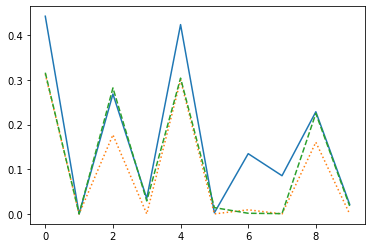

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning:

invalid value encountered in sqrt



In [11]:
# We use this upper-triangular to matrix routine as covariance matrices are symmetric,
# so in the optimisation routine below where we adjust a Gaussian to suit the sketches,
# we only adjust the upper half
def upper_tri_to_matrix(upper_tri, size):
    mat = np.zeros((size,size))
    mat[np.triu_indices(size)] = upper_tri
    return mat + mat.T - np.diag(np.diag(mat))
def mean_covar_2_theta(mean, covar):
    return np.concatenate((mean, covar[np.triu_indices(d)]))
def theta_2_mean_covar(theta):
    mean = theta[:d]
    covar = upper_tri_to_matrix(theta[d:], d)    
    return mean, covar

# We define a function that returns the characteristic of the gaussian
def guassian_characteristic(theta, omega):
    mean, covar = theta_2_mean_covar(theta)
    # Note below we use (omega * (covar @ omega)).sum(axis=0) instead of, e.g. omega @ (covar @ omega)
    # as omega can be a matrix (i.e it is a collection of sketch frequencies), in which case this
    # routine will provide a vector of values corresponding to each sketch freq.
    
    # NOTE: This *should* be the complex characteristic, but as explained above the optimization doesn't work...
    complex_result = (1/np.sqrt(omega.size)) * np.exp(-1.j * omega.T @ mean) * np.exp(-0.5 * (omega * (covar @ omega)).sum(axis=0))
    #return complex_result
    result = np.zeros(2*complex_result.size)
    result[0::2] = np.real(complex_result)
    result[1::2] = np.imag(complex_result)
    return result
    
def guassian_characteristic_prime(theta, omega):
    # The first derivative. Returns a matrix of size (r * (d+d^2))
    # First we need to calculate the outer prod of the omega for the covar dependence
    omega_outers = omega[np.newaxis,:,:].T * omega.T[:,np.newaxis,:]
    # This is a rather involved routine that turns the omega in to a list of outer prods
    omega_outers_flat_uppertri = omega_outers[:, np.triu_indices(d)[0], np.triu_indices(d)[1]]
    
    #return (np.hstack((-1.j * omega.T, -0.5 * omega_outers_flat_uppertri)).T * guassian_characteristic(theta, omega)).T
    mean, covar = theta_2_mean_covar(theta)
    complex_result = (1/np.sqrt(omega.size)) * (np.hstack((-1.j * omega.T, -0.5 * omega_outers_flat_uppertri)).T * np.exp(-1.j * omega.T @ mean) * np.exp(-0.5 * (omega * (covar @ omega)).sum(axis=0))).T
    result = np.zeros((complex_result.shape[0]*2, complex_result.shape[1]))
    result[0::2] = np.real(complex_result)
    result[1::2] = np.imag(complex_result)
    return result

#np.exp( - 1.j * np.dot(omega, mu)) * np.exp(-0.5 * np.dot(omega, Sigma @ omega))

# Input: 
# r      The vector of sketches of the data to be matched (in practice is the residual empirical sketch)
# freqs  The sketch frequencies
#
# Output:
# mu    The mean
# sigma The covariance
def find_correlated_gaussian(r, freqs, theta0):
    def g_c_min_obj(theta):
        return guassian_characteristic(theta, freqs) - r
    def g_c_jac(theta):
        return guassian_characteristic_prime(theta, freqs)

    covar_bounds = ([-np.inf, -np.inf, 0., -np.inf, 0.], [np.inf, np.inf,np.inf, np.inf, np.inf])
    return sp.optimize.least_squares(g_c_min_obj, theta0, jac=g_c_jac, method='dogbox', xtol=1e-8)

pca_covar = pca_phi @ (pca_phi * pca_sigma_sq).T
pca_theta = mean_covar_2_theta(mean, pca_covar)
#pca_theta = np.concatenate((np.zeros(2), (4*np.eye(2))[np.triu_indices(d)]))
np.random.seed(1)
min_results = find_correlated_gaussian(z, sketch_freqs, pca_theta * (1 + 0.1 * np.random.random(pca_theta.shape)))
new_mean, new_covar = theta_2_mean_covar(min_results.x)
new_sig_sq, new_phi = np.linalg.eigh(new_covar)

plt.plot(np.abs(z))
plt.plot(np.abs(guassian_characteristic(pca_theta, sketch_freqs)), ':')
plt.plot(np.abs(guassian_characteristic(min_results.x, sketch_freqs)), '--')
plt.show()

fig_pca = [make_ellipse(mean, pca_phi, np.sqrt(pca_sigma_sq)), 
           make_ellipse(mean, pca_phi, 2*np.sqrt(pca_sigma_sq)),
           go.Scatter(x=[mean[0]], y=[mean[1]], mode='markers', marker=mean_marker, showlegend=False)]
fit_mean_marker = mean_marker
fit_mean_marker['line']['color']=cma_2_rgbstr(cm[-2], 0.5)
mean_marker['color']=cma_2_rgbstr(cm[-2], 0.5)
fig_fit = [make_ellipse(new_mean, new_phi, np.sqrt(new_sig_sq), color=cm[-2]), 
           make_ellipse(new_mean, new_phi, 2*np.sqrt(new_sig_sq), color=cm[-2]),
           go.Scatter(x=[new_mean[0]], y=[new_mean[1]], mode='markers', marker=fit_mean_marker, showlegend=False)]

fig = go.Figure(data=fig_data + fig_fit + fig_pca + fig_sketch_freqs, layout=layout)
fig.layout['title']['text']=f'PCA of data points'
offline.iplot(fig)

### Ok, lets parameterise $\Sigma$ in terms of an angle and two singular values

$$
\Sigma = 
\begin{bmatrix} 
\cos \phi & -\sin \phi \\
\sin \phi & \cos \phi
\end{bmatrix}
\begin{bmatrix} 
\sigma_1 & 0 \\
0 & \sigma_2
\end{bmatrix}
\begin{bmatrix} 
\cos \phi & -\sin \phi \\
\sin \phi & \cos \phi
\end{bmatrix}^T
=
\begin{bmatrix} 
\sigma_1 \cos^2 \phi + \sigma_2 \sin^2 \phi & (\sigma_1 - \sigma_2) \sin \phi \cos \phi \\
(\sigma_1 - \sigma_2) \sin \phi \cos \phi & \sigma_1 \sin^2 \phi + \sigma_2 \cos^2 \phi \\
\end{bmatrix}
$$

Unfortunately this makes the Jacobian annoying as

$$
\omega^T \Sigma \omega
= 
\omega_1^2 (\sigma_1 \cos^2 \phi + \sigma_2 \sin^2 \phi)
+ \omega_2^2 (\sigma_1 \sin^2 \phi + \sigma_2 \cos^2 \phi)
+ 2 \omega_1 \omega_2 (\sigma_1 - \sigma_2) \sin \phi \cos \phi
$$

so

$$
\begin{aligned}
\frac{\partial \left(\frac{1}{2} \omega^T \Sigma \omega\right)}{\partial \phi}
&= 
- (\omega_1^2 - \omega_2^2) (\sigma_1 - \sigma_2) \cos \phi \sin \phi
+ \omega_1 \omega_2 (\sigma_1 - \sigma_2) (\cos^2 \phi - \sin^2 \phi)
\\
\frac{\partial \left(\frac{1}{2} \omega^T \Sigma \omega\right)}{\partial \sigma_1}
&=
\frac{1}{2} (\omega_1^2 \cos^2 \phi + \omega_2^2 \sin^2 \phi) + \omega_1 \omega_2 \sin \phi \cos \phi
\\
\frac{\partial \left(\frac{1}{2} \omega^T \Sigma \omega\right)}{\partial \sigma_1}
&=
\frac{1}{2} (\omega_1^2 \sin^2 \phi + \omega_2^2 \cos^2 \phi) - \omega_1 \omega_2 \sin \phi \cos \phi
\end{aligned}
$$

In [73]:
# We use this upper-triangular to matrix routine as covariance matrices are symmetric,
# so in the optimisation routine below where we adjust a Gaussian to suit the sketches,
# we only adjust the upper half
def deg_sig_to_matrix(deg_sig):
    c, s = np.cos(deg_sig[0]), np.sin(deg_sig[0])
    R = np.array(((c, -s), (s, c)))
    sig = np.diag(deg_sig[1:])
    return R @ sig @ R.T
def mean_covar_2_deg_sig_theta(mean, covar):
    sig, R = np.linalg.eigh(covar)
    sig = sig[::-1]; R = R[:,::-1]
    deg = np.arccos(R[0,0])
    if R[0,1] > 0:
        deg = 2*np.pi - deg
    return np.concatenate((mean, np.array([deg]), sig))
def deg_sig_theta_2_mean_covar(theta):
    mean = theta[:2]
    covar = deg_sig_to_matrix(theta[2:])
    return mean, covar

# We define a function that returns the characteristic of the gaussian
def guassian_characteristic_deg_sig(theta, omega):
    mean, covar = deg_sig_theta_2_mean_covar(theta)
    # Note below we use (omega * (covar @ omega)).sum(axis=0) instead of, e.g. omega @ (covar @ omega)
    # as omega can be a matrix (i.e it is a collection of sketch frequencies), in which case this
    # routine will provide a vector of values corresponding to each sketch freq.
    
    # NOTE: This *should* be the complex characteristic, but as explained above the optimization doesn't work...
    complex_result = (1/np.sqrt(omega.size)) * np.exp(-1.j * omega.T @ mean) * np.exp(-0.5 * (omega * (covar @ omega)).sum(axis=0))

    #return complex_result
    result = np.zeros(2*complex_result.size)
    result[0::2] = np.real(complex_result)
    result[1::2] = np.imag(complex_result)
    return result
    
def guassian_characteristic_prime(theta, omega):
    return None

# Input: 
# r      The vector of sketches of the data to be matched (in practice is the residual empirical sketch)
# freqs  The sketch frequencies
#
# Output:
# mu    The mean
# sigma The covariance
def find_correlated_gaussian(r, freqs, theta0):
    def g_c_min_obj_deg_sig(theta):
        return guassian_characteristic_deg_sig(theta, freqs) - r
    def g_c_jac(theta):
        return None

    covar_bounds = ([-np.inf, -np.inf, 0., 0.0, 0.0], [np.inf, np.inf, 2*np.pi, np.inf, np.inf])
    return sp.optimize.least_squares(g_c_min_obj_deg_sig, theta0, method='dogbox', bounds=covar_bounds, xtol=1e-8)

pca_covar = pca_phi @ (pca_phi * pca_sigma_sq).T
pca_theta = mean_covar_2_deg_sig_theta(mean, pca_covar)
np.random.seed(1)
pca_theta *= (1 + 1 * np.random.random(pca_theta.shape))
pca_theta[:2] = np.random.random(2)
min_results = find_correlated_gaussian(z, sketch_freqs, pca_theta)
new_mean, new_covar = deg_sig_theta_2_mean_covar(min_results.x)
new_sig_sq, new_phi = np.linalg.eigh(new_covar)

print(pca_theta)
print(min_results.x)

#plt.plot(np.abs(z))
#plt.plot(np.abs(guassian_characteristic(pca_theta, sketch_freqs)), ':')
#plt.plot(np.abs(guassian_characteristic(min_results.x, sketch_freqs)), '--')
#plt.show()

fig_pca = [make_ellipse(mean, pca_phi, np.sqrt(pca_sigma_sq)), 
           make_ellipse(mean, pca_phi, 2*np.sqrt(pca_sigma_sq)),
           go.Scatter(x=[mean[0]], y=[mean[1]], mode='markers', marker=mean_marker, showlegend=False)]
fit_mean_marker = mean_marker
fit_mean_marker['line']['color']=cma_2_rgbstr(cm[-3], 0.5)
mean_marker['color']=cma_2_rgbstr(cm[-3], 0.5)
c, s = np.cos(pca_theta[2]), np.sin(pca_theta[2])
x0_phi = np.array(((c, -s), (s, c)))
fig_x0 =  [make_ellipse(pca_theta[:2], x0_phi, np.sqrt(pca_theta[3:]), color=cm[-3]), 
           make_ellipse(pca_theta[:2], x0_phi, 2*np.sqrt(pca_theta[3:]), color=cm[-3]),
           go.Scatter(x=[pca_theta[0]], y=[pca_theta[1]], mode='markers', marker=mean_marker, showlegend=False)]
fit_mean_marker = mean_marker
fit_mean_marker['line']['color']=cma_2_rgbstr(cm[-2], 0.5)
mean_marker['color']=cma_2_rgbstr(cm[-2], 0.5)
fig_fit = [make_ellipse(new_mean, new_phi, np.sqrt(new_sig_sq), color=cm[-2]), 
           make_ellipse(new_mean, new_phi, 2*np.sqrt(new_sig_sq), color=cm[-2]),
           go.Scatter(x=[new_mean[0]], y=[new_mean[1]], mode='markers', marker=fit_mean_marker, showlegend=False)]

fig = go.Figure(data=fig_data + fig_fit + fig_pca + fig_x0 + fig_sketch_freqs, layout=layout)
fig.layout['title']['text']=f'PCA of data points'
offline.iplot(fig)

[0.09233859 0.18626021 3.39357818 0.64450532 0.16586146]
[-0.27020764  0.09095043  2.81787052  0.28839215  0.        ]
